In [1]:
# !pip install tensorflow


In [1]:
import sys
from pathlib import Path

# Zum übergeordneten Ordner 'src' wechseln
current_path = Path().resolve()
src_path = current_path.parents[4]  # Zwei Stufen nach oben

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

src_path


WindowsPath('C:/Users/Nasiba/Documents/1 Master Data Science/Projektpraktikum/WebScience24')

In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

pd.set_option('display.max_colwidth', None)

from vector_functions import  vectorize_fasttext, vectorize_fasttext_test_data, vectorize_fasttext_words, vectorize_fasttext_test_data_words

import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from tensorflow.keras.models import Sequential

from tensorflow.keras.metrics import Recall
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef



#### Beladung der Daten

In [3]:

source_filepath_name = os.path.abspath(os.path.join(src_path, 'data/twitter_hate-speech/train_cleaned_rnn.csv'))

df_cleaned = pd.read_csv(source_filepath_name, encoding='utf-8', index_col=0)

source_filepath_name_test = os.path.abspath(os.path.join(src_path, 'data/twitter_hate-speech/test_cleaned_rnn.csv'))

df_cleaned_test = pd.read_csv(source_filepath_name_test, encoding='utf-8', index_col=0)

print(df_cleaned.count())

label            20289
tweet            20289
tweet_cleaned    20288
user_handle      20289
hashtags         20289
emojis            4220
dtype: int64


### Vektorisierung

In [13]:



X_train_vectors_fast, X_test_vectors_fast, y_train_fast, y_test_fast, ft_model,tokenizer_fast = vectorize_fasttext(df=df_cleaned, text_column ="tweet_cleaned", label_column="label")

X_test_data_vectors_test_fast , y_test_data_test_fast, ft_model_test,tokenizer_test_fast = vectorize_fasttext_test_data(df=df_cleaned_test, text_column ="tweet_cleaned", label_column="label",  tokenizer=tokenizer_fast)


c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\Training\Phase_1\vector_functions.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


In [5]:
X_train_vectors_fast = np.expand_dims(X_train_vectors_fast, axis=1)
X_test_vectors_fast = np.expand_dims(X_test_vectors_fast, axis=1)
X_test_data_vectors_test_fast = np.expand_dims(X_test_data_vectors_test_fast, axis=1)
print(X_train_vectors_fast.shape)
print(X_test_data_vectors_test_fast.shape)


(14201, 1, 200)
(9093, 1, 200)


In [4]:



X_train_vectors_fast_word, X_test_vectors_fast_word, y_train_fast_word, y_test_fast_word, ft_model_word = vectorize_fasttext_words(df=df_cleaned, text_column ="tweet_cleaned", label_column="label")

X_test_data_vectors_test_fast_word , y_test_data_test_fast_word, ft_model_test= vectorize_fasttext_test_data_words(df=df_cleaned_test, text_column ="tweet_cleaned", label_column="label")


c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\Training\Phase_1\vector_functions.py:399: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


#### Modeltraining mit Fasttext

(Aktivierungsfunktion in der Dense-Schicht zu sigmoid ändern,class_wight hinzufügen)

In [5]:
samples, max_seq_len, vector_size = X_train_vectors_fast.shape
num_classes = len(np.unique(y_train_fast))


# Modellinitialisierung
model_fast = Sequential()

# LSTM-Schicht
model_fast.add(LSTM(units=128, input_shape=(1, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model_fast.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model_fast.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells
model_fast.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall()])

class_weight = {0: 1, 1: 3} 
history_fast = model_fast.fit(
    X_train_vectors_fast, np.array(y_train_fast),
    validation_data=(X_test_vectors_fast, np.array(y_test_fast)),
    epochs=10,
    batch_size=32,
    class_weight=class_weight,
    verbose=2
)
# Vorhersagen auf Testdaten
predictions_fast = model_fast.predict(X_test_data_vectors_test_fast)
threshold = 0.35  
predicted_classes_fast= (predictions_fast > threshold).astype(int)

NameError: name 'X_train_vectors_fast' is not defined

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.99      0.02      0.04      8468
     Class 1       0.07      1.00      0.13       625

    accuracy                           0.09      9093
   macro avg       0.53      0.51      0.08      9093
weighted avg       0.93      0.09      0.04      9093

[[ 157 8311]
 [   1  624]]


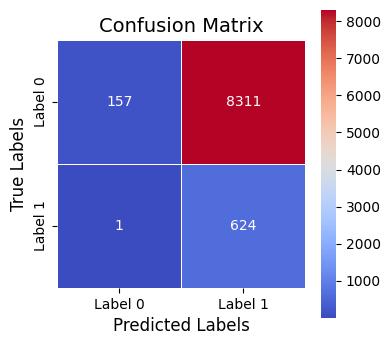

In [ ]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data_test_fast, predicted_classes_fast, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data_test_fast, predicted_classes_fast)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

In [5]:
X_train_vectors_fast_word = np.expand_dims(X_train_vectors_fast_word, axis=1)
X_test_vectors_fast_word = np.expand_dims(X_test_vectors_fast_word, axis=1)
X_test_data_vectors_test_fast_word = np.expand_dims(X_test_data_vectors_test_fast_word, axis=1)
print(X_train_vectors_fast_word.shape)
print(X_test_data_vectors_test_fast_word.shape)
print(X_test_data_vectors_test_fast_word.shape)


(14201, 1, 200)
(9093, 1, 200)
(9093, 1, 200)


In [6]:
samples, max_seq_len, vector_size = X_train_vectors_fast_word.shape
num_classes = len(np.unique(y_train_fast_word))


# Modellinitialisierung
model_fast_word = Sequential()

# LSTM-Schicht
model_fast_word.add(LSTM(units=128, input_shape=(1, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model_fast_word.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model_fast_word.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells
model_fast_word.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall()])

class_weight = {0: 1, 1: 3} 
history_fast_word = model_fast_word.fit(
    X_train_vectors_fast_word, np.array(y_train_fast_word),
    validation_data=(X_test_vectors_fast_word, np.array(y_test_fast_word)),
    epochs=10,
    batch_size=32,
    class_weight=class_weight,
    verbose=2
)


Epoch 1/10


C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


444/444 - 4s - 9ms/step - accuracy: 0.9273 - loss: 0.3931 - recall: 0.2171 - val_accuracy: 0.9269 - val_loss: 0.1847 - val_recall: 0.2010
Epoch 2/10
444/444 - 2s - 4ms/step - accuracy: 0.9178 - loss: 0.3462 - recall: 0.3909 - val_accuracy: 0.9179 - val_loss: 0.2059 - val_recall: 0.4092
Epoch 3/10
444/444 - 2s - 4ms/step - accuracy: 0.9207 - loss: 0.3387 - recall: 0.4179 - val_accuracy: 0.9231 - val_loss: 0.1940 - val_recall: 0.3656
Epoch 4/10
444/444 - 2s - 4ms/step - accuracy: 0.9192 - loss: 0.3377 - recall: 0.4287 - val_accuracy: 0.9210 - val_loss: 0.1967 - val_recall: 0.4068
Epoch 5/10
444/444 - 2s - 4ms/step - accuracy: 0.9244 - loss: 0.3295 - recall: 0.4536 - val_accuracy: 0.9031 - val_loss: 0.2364 - val_recall: 0.6271
Epoch 6/10
444/444 - 2s - 4ms/step - accuracy: 0.9233 - loss: 0.3228 - recall: 0.4708 - val_accuracy: 0.9266 - val_loss: 0.1810 - val_recall: 0.3632
Epoch 7/10
444/444 - 2s - 4ms/step - accuracy: 0.9244 - loss: 0.3237 - recall: 0.4741 - val_accuracy: 0.9266 - val_lo

In [7]:
# Vorhersagen auf Testdaten
predictions_fast_word = model_fast_word.predict(X_test_data_vectors_test_fast_word)
threshold = 0.35  
predicted_classes_fast_word= (predictions_fast_word > threshold).astype(int)

285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


⚡ F1-Score (Klasse 2): 0.2339
🔄 Recall (Klasse 2): 0.9360
🎯 Precision (Klasse 2): 0.1336
✅ Accuracy (gesamt): 0.5785
🔗 MCC: 0.2471
Confusion Matrix:
 [[4675 3793]
 [  40  585]]


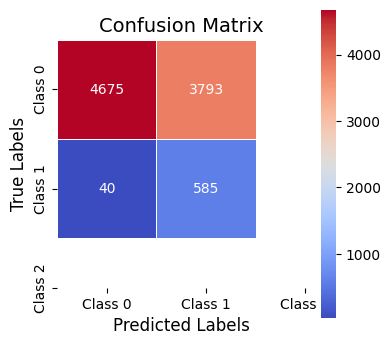

In [ ]:
# Klassifikationsbericht erstellen (als Dictionary)
report = classification_report(y_test_data_test_fast_word, predicted_classes_fast_word, output_dict=True)

# Metriken NUR für Klasse 2 extrahieren
precision_class_2 = report["1"]["precision"]
recall_class_2 = report["1"]["recall"]
f1_class_2 = report["1"]["f1-score"]

# Gesamtgenauigkeit berechnen
accuracy = accuracy_score(y_test_data_test_fast_word, predicted_classes_fast_word)

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test_data_test_fast_word, predicted_classes_fast_word)

# Ergebnisse ausgeben (nur für Klasse 2)
print(f" F1-Score (Klasse 2): {f1_class_2:.4f}")
print(f" Recall (Klasse 2): {recall_class_2:.4f}")
print(f" Precision (Klasse 2): {precision_class_2:.4f}")
print(f" Accuracy (gesamt): {accuracy:.4f}")
print(f" MCC: {mcc:.4f}")

# Confusion Matrix berechnen
cm = confusion_matrix(y_test_data_test_fast_word, predicted_classes_fast_word)
print("Confusion Matrix:\n", cm)

# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.99      0.55      0.71      8468
     Class 1       0.13      0.94      0.23       625

    accuracy                           0.58      9093
   macro avg       0.56      0.74      0.47      9093
weighted avg       0.93      0.58      0.68      9093

[[4675 3793]
 [  40  585]]


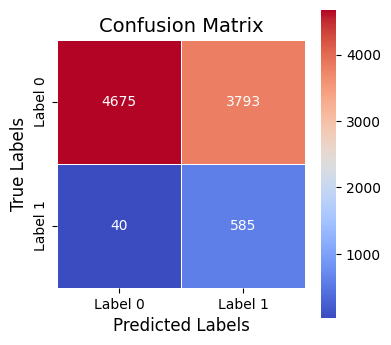

In [11]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data_test_fast_word, predicted_classes_fast_word, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data_test_fast_word, predicted_classes_fast_word)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()